# Project
- Adult dataset, whose interest is to **predict the income level (binary classifcation problem) larger than 50K or not** based on **14 attributes**
- We will build up ML model to make prediction from these 14 attributes 

# Remarks:
- Here, we do not save the model as .pmml file!

## Important !!
- **We save the optimal hyper-parameters in dictionary (in jupyter notebook) for simplicity**
    - **You can check the agreement with the grid search result (not fake!)**
    - **Do not run grid-search (CV) since it costs much time!**

# Pipeline of Project:
- 1. **EDA** of raw data, combining with **visualization**.
    - during this process, we will also **do the data cleaning job**;
        - especially for null values detection, as we will come from this issues during the visualization process
    - to gain some insights from the data through visualization;
        - **one insight is: Normalization is complusory for this task!**
    - to achieve precise understanding of dataset, which will bring benefits to following model building process;
- 2. Pre-process the data, into the form that can **directly** feed into the ML model.
    - one-hot encoding for categorical data;
    - split the data into **training set** and **testing set**;
        - use CV to select models, which means **no need for validation set**;
    - do normalization (standardization);
        - this step is **necessary**!!! Reasons:
            - 1. **outliers exist in some attributes from the result of EDA**
            - 2. our algo will use GD to solve optimization problem, requires the landscape of loss function not too ill-conditioned **for better convergence rate**
- 3. Build **supervised learning method** to handle **binary classfication task**.
    - Model included:
        - DT **(Baseline)**;
        - Logistic Regression;
        - Kernel SVM;
            - In this part, we will **do one toy experiment** to **illustrate the power of 'normalization'**.
        - Random Forest + Xgboost;
    - Model training architecture:
        - for **DT**, we fix the hyper-parameter (baseline) and **use a small depth number** to make visualization clearly;
        - for **other models**, we will apply the **Cross-Validation fashion** to **select the optimal hyper-parameters**;
            - for **probabilistic models**, we will select optimal threshold according to f1-score in training data
            - use the optimal threshold to evaluate model performance
    - We will **give some insights/remarks** from the results of well-tuned model;
    - Comparison will be done through different models under some performance metrics **(Evaluation Part)**;
- 4. Apply **unsupervised learning method** to achieve **dimensionality reduction**.
    - Model included:
        - t-SNE;
            - visualization
        - PCA;
            - We will determine the **reduced dimension** by setting threshold for **explained variance ratio*;
- 5. Re-train **supervised learning** model based on the **features after dimensionality reduction**.
    - Model included:
        - Random Forest + Xgboost;
    - We will make comparison between the results before dimensionality reduction and that after dimensionality reduction;
     

# 0a. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# data process tools
import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

# data pre-process
from sklearn import preprocessing

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ML model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import xgboost as xgb
from sklearn import svm
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA

# model selection
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# performance metric
import shap
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score

# 0b. Pre-defined variables and functions

In [2]:
# variable part
data_file = 'adult.data'

In [3]:
# function part

## --------------------------------------Visualizaton funcitons------------------------------------------
# function to plot PR curve
## input ground-truth label and predicted label
### return PR-curve and corresponding threshold, precison, record, f1-scores
def plot_pr(y, pred):
    # based on different thresholds
    precision, recall, thresholds = precision_recall_curve(y, pred)

    f1_scores = []
    for i in range(len(thresholds)):
        f1_scores.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
    
    # select the best model according to the f1-score
    ix = np.argmax(f1_scores)
#     print('Best threshold: ', thresholds[ix])
#     print('Best F1-Score: ', np.max(f1_scores))

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best')

    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

    return thresholds[ix], precision, recall, thresholds, f1_scores


# fucntion to display EDA
## col2 represents the label
### col1 reprensts the features
#### is_cat = True, then histogram; is_cat = False, then density figure

def display_kdeplot(df, col1, col2, is_cat):
    #df[col1] = df[col1].astype(float)
    f, ax1 = plt.subplots(figsize = (12, 4))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
        plt.title(col1)
    else:
        df[col1] = df[col1].astype(float)
        sns.kdeplot(data = df[df[col2] == 1], x = col1, color = 'darkorange', label = '1', ax = ax1)
        
        ax2 = ax1.twinx()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, label = '0', ax = ax2)
        
        plt.title(col1)
        ax1.legend(loc = 'upper left')
        ax2.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show()
    
    print('=========================================================================================')
    print('Feature name: {}'.format(col1))
    print('Descriptive information:')
    print(df.groupby(col2)[col1].describe())
    print('=========================================================================================')
   
    
# function to show the total contents of categorical data
def display_content_cate(df, categorical_feature_list):
    for cate_feature in categorical_feature_list:
        print('=========================================================================================')
        print('Feature name: {}'.format(cate_feature))
        print('Total value: {}'.format(df[cate_feature].unique()))
        print('Number of different values: {}'.format(df[cate_feature].nunique()))


    
## --------------------------------------Training funcitons------------------------------------------
# given total data, feature list, testing set parameter
## return corresponding training and testing set
def train_test_generation(df, features_to_use, target, test_size, random_state):
    # only select the features we need
    feature_list = features_to_use + target
    df = df[feature_list].astype(float)
    y = df[target]
    
    df_train, df_test, y_train, y_test = train_test_split(df, y, test_size = test_size, random_state = random_state)
    
    X_train, X_test = df_train[features_to_use], df_test[features_to_use]
    
    print('=========================================================================================')
    print('Label distribution:\n{} (training)'.format(y_train.value_counts()))
    print('=========================================================================================')
    print('=========================================================================================')
    print('Label distribution:\n{} (testing)'.format(y_test.value_counts()))
    print('=========================================================================================')
    
    return X_train, y_train, X_test, y_test, df_test

# given ground-truth label and predicted label
## return all performance metric
def display_model_metrics(y, y_pred):
    print('     F1 score:', f1_score(y, y_pred))
    print('     AUC:', roc_auc_score(y, y_pred))
    print('     Accuracy:', accuracy_score(y, y_pred))
    print('     Precision:', precision_score(y, y_pred))
    print('     Recall:', recall_score(y, y_pred))
    print("\tConfusion matrix：\n", confusion_matrix(y, y_pred))
    
# given model (non-parametrized classifier), grid parameters, cross-valdiation folds, dataset
## return best parameters
def model_grid_search(clf_gs, param_grid, cv, x, y):
    grid_search = GridSearchCV(estimator = clf_gs,
                            param_grid = param_grid,
                            scoring = 'roc_auc',
                            cv = cv,
                            verbose = 1,
                            n_jobs = 1
                            )
    grid_search.fit(x, y)
    best_param = grid_search.best_params_
   
        
    print('====> grid search parameters: \n{')
    [print(key,':',value) for key, value in param_grid.items()]
    print('}\n')
        
    print('====> best estimator: \n{')
    [print(key,':',value) for key, value in best_param.items()]
    print('}\n')
    
    return best_param


# given parametrized model, splited data (training + testing), threshold (for confusion matrix) and
# feature list (for feature importance),
## return feature importance, training and testing confusion matrix, shapley value, PR-curve and 
## probability prediction
#### ONLY APPLY TO probabilistic model!!!!
def model_train_evaluation_prob_mod(mod, X_train, y_train, X_test, y_test, 
                is_feature_importance, is_shap, is_plot_pr):
    
    mod.fit(X_train, y_train)
    
    # model prediction on training set
    # y_train_preds = mod.predict(X_train)
    y_train_preds_prob = mod.predict_proba(X_train)
    
    # select optimal threshold according to F1-score **rougly**
    candidate_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    f1score_array = np.zeros(9)
    
    for i in range(9):
        threshold = candidate_threshold[i]
        train_preds = [1 if y_train_preds_prob[i][1] > threshold else 0 for i in range(len(y_train_preds_prob))]
        f1score_array[i] = f1_score(y_train, train_preds)
    
    optimal_index = f1score_array.argmax()
    optimal_threshold = candidate_threshold[optimal_index]
    
    print("=============================================================================================")
    print(r"Candidate threshold: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]")
    print("F1-score records: {}".format(f1score_array))
    print("Optimal threshold (Roughly): {}".format(optimal_threshold))
    
    # model prediction on training set through optimal threshold
    train_preds = [1 if y_train_preds_prob[i][1] > optimal_threshold else 0 for i in range(len(y_train_preds_prob))]
    print("\n=============================================================================================")
    print(f'Train:')
    print('Label distribution:\n{}\n'.format(y_train.value_counts()))
    display_model_metrics(y_train, train_preds)
    
    
    # model prediction on testing set through optimal threshold
    # y_test_preds = mod.predict(X_test)
    y_test_preds_prob = mod.predict_proba(X_test)
    test_preds = [1 if y_test_preds_prob[i][1] > optimal_threshold else 0 for i in range(len(y_test_preds_prob))]
    print("\n=============================================================================================")
    print('Testing:')
    print('Label distribution:\n{}\n'.format(y_test.value_counts()))
    display_model_metrics(y_test, test_preds)
    
    output_list = [mod]

    
    # feature importance
    if is_feature_importance is True:
        print("=============================================================================================")
        print(pd.DataFrame({'feature': list(features_to_use),
               'importance': mod.feature_importances_}).\
                sort_values('importance', ascending = False))
        
    # shapley value
    if is_shap is True:
        print("=============================================================================================")
        print('SHAP explanation: \n')
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_test)
        try: 
            shap.summary_plot(shap_values[1], X_test, max_display=30)
        except:
            shap.summary_plot(shap_values, X_test, max_display=30)
    
    # thres is optimal threshold w.r.t f1-score
    # precision-recall curve
    if is_plot_pr is True:
        print("=============================================================================================")
        print("testing:")
        thres, precision, recall, thresholds, f1_scores = plot_pr(y_test, y_test_preds_prob[:, 1])
        output_list.append([thres, precision, recall, thresholds, f1_scores])
    
    return output_list, y_test_preds_prob[:,1], test_preds

# 1. EDA

## 1.1 Data loading

In [4]:
data_col = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']
data = pd.read_csv(data_file, header = None, names = data_col)

In [5]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


- observation: 'fnlwgt' attribute represents the 'index', which means that we should kick it out to make prediction

In [6]:
features = ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label'] 
data = data[features]

In [7]:
data.head(10)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


- translate the label into 0/1 scalar
    - '>50K': 1
    - '<=50K': 0

In [8]:
data['label'] = data['label'].apply(lambda x: 0 if x == ' <=50K' else 1)

In [9]:
data[data['label']==1].head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1
10,37,Private,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1
11,30,State-gov,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,1


## 1.2 Analysis and visualization
- Here we **conduct EDA**
- Meanwhile, we will do **data cleaning**, which may focus on dealing with **null values**

### check some basic information about dataset

- (# of data samples, # of features)

In [10]:
data.shape

(32561, 14)

- data types checking
    - 'int' means numerical data;
    - 'object' means categorical data;

In [11]:
for i in data.columns:
    print(f"The column {i}'s dtype is {data.loc[:,i].dtype}")

The column age's dtype is int64
The column workclass's dtype is object
The column education's dtype is object
The column education-num's dtype is int64
The column marital-status's dtype is object
The column occupation's dtype is object
The column relationship's dtype is object
The column race's dtype is object
The column sex's dtype is object
The column capital-gain's dtype is int64
The column capital-loss's dtype is int64
The column hours-per-week's dtype is int64
The column native-country's dtype is object
The column label's dtype is int64


- for categorical data, check the value of its content

In [12]:
categorical_feature = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
display_content_cate(data, categorical_feature)

Feature name: workclass
Total value: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
Number of different values: 9
Feature name: education
Total value: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
Number of different values: 16
Feature name: marital-status
Total value: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
Number of different values: 7
Feature name: occupation
Total value: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
Number of different values: 15
Feature name: relationship
Tot

- through checking, we can see that:
    - in some attributes, there exists '?' value
    - in order to guarantee the accuracy of our algorithms, we should conduct some actions to this
- further check the count numbers of those '?' value

In [13]:
data[(data['workclass'] == ' ?') | (data['occupation'] == ' ?') | (data['native-country'] == ' ?')].shape

(2399, 14)

- since the **null part** only constitutes **no more than 1/10** of the whole dataset, we kick them out

In [14]:
data = data[(data['workclass'] != ' ?') & (data['occupation'] != ' ?') & (data['native-country'] != ' ?')]

In [15]:
data.shape

(30162, 14)

- check the value of content for categorical data **after dropping null value**

In [16]:
display_content_cate(data, categorical_feature)

Feature name: workclass
Total value: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']
Number of different values: 7
Feature name: education
Total value: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']
Number of different values: 16
Feature name: marital-status
Total value: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
Number of different values: 7
Feature name: occupation
Total value: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Transport-moving' ' Farming-fishing'
 ' Machine-op-inspct' ' Tech-support' ' Craft-repair' ' Protective-serv'
 ' Armed-Forces' ' Priv-house-serv']
Number of different values: 14
Feature name: relationship
Total value: [' Not-in-family

### Visualization

- 1. **'kdeplot'** for interested attributes

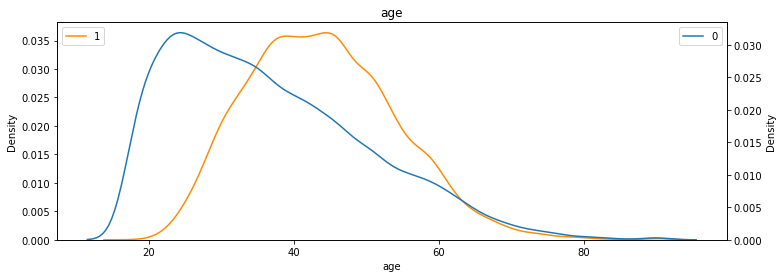

Feature name: age
Descriptive information:
         count      mean        std   min   25%   50%   75%   max
label                                                            
0      22654.0  36.60806  13.464631  17.0  26.0  34.0  45.0  90.0
1       7508.0  43.95911  10.269633  19.0  36.0  43.0  51.0  90.0


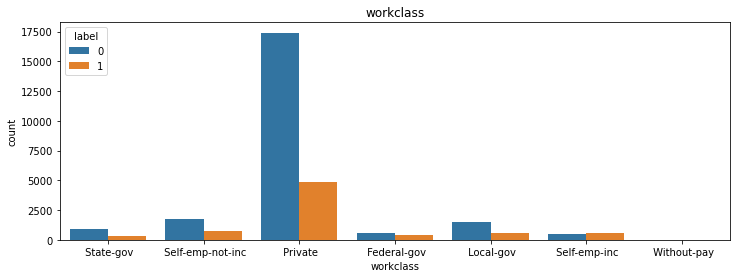

Feature name: workclass
Descriptive information:
       count unique       top   freq
label                               
0      22654      7   Private  17410
1       7508      6   Private   4876


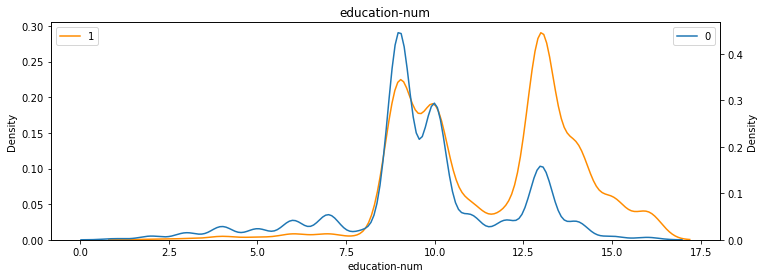

Feature name: education-num
Descriptive information:
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      22654.0   9.629116  2.413596  1.0   9.0   9.0  10.0  16.0
1       7508.0  11.606420  2.368423  2.0  10.0  12.0  13.0  16.0


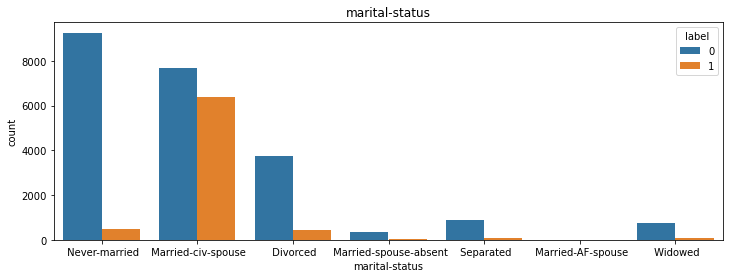

Feature name: marital-status
Descriptive information:
       count unique                  top  freq
label                                         
0      22654      7        Never-married  9256
1       7508      7   Married-civ-spouse  6399


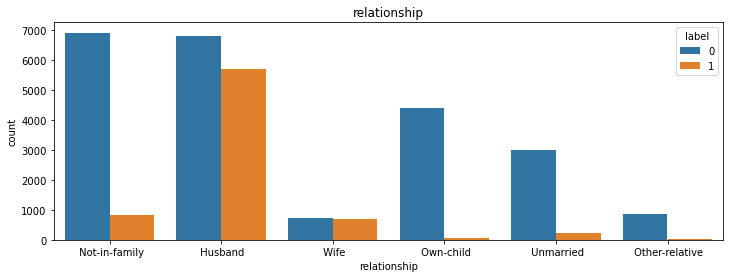

Feature name: relationship
Descriptive information:
       count unique             top  freq
label                                    
0      22654      6   Not-in-family  6903
1       7508      6         Husband  5679


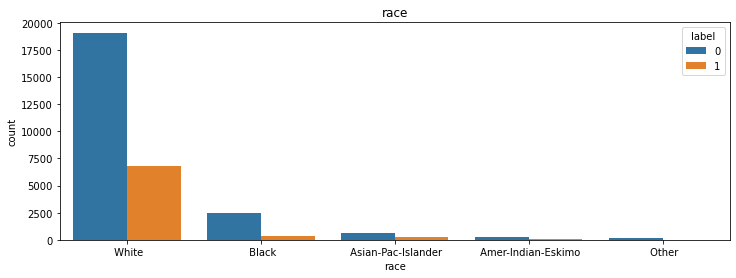

Feature name: race
Descriptive information:
       count unique     top   freq
label                             
0      22654      5   White  19094
1       7508      5   White   6839


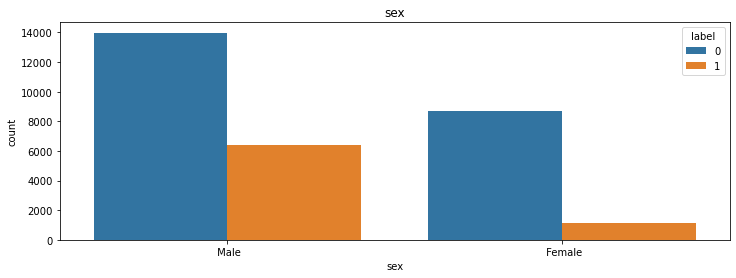

Feature name: sex
Descriptive information:
       count unique    top   freq
label                            
0      22654      2   Male  13984
1       7508      2   Male   6396


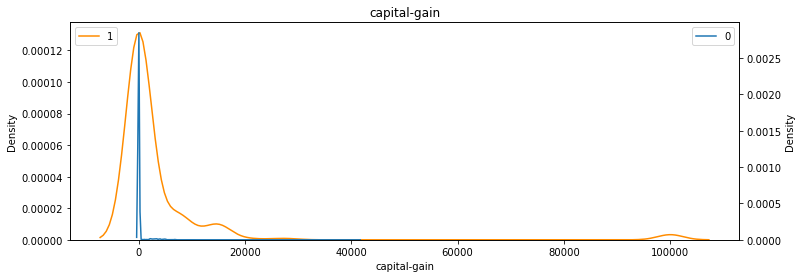

Feature name: capital-gain
Descriptive information:
         count         mean           std  min  25%  50%  75%      max
label                                                                 
0      22654.0   148.893838    936.392280  0.0  0.0  0.0  0.0  41310.0
1       7508.0  3937.679808  14386.060019  0.0  0.0  0.0  0.0  99999.0


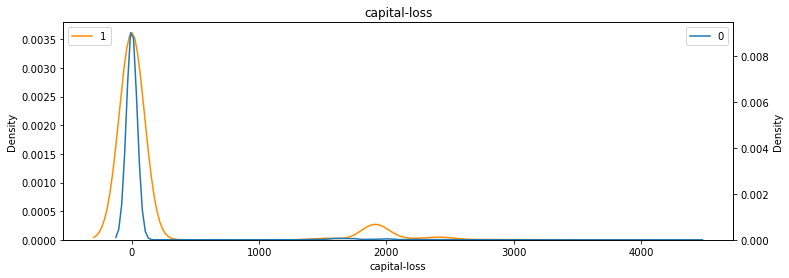

Feature name: capital-loss
Descriptive information:
         count        mean         std  min  25%  50%  75%     max
label                                                             
0      22654.0   53.448000  310.270263  0.0  0.0  0.0  0.0  4356.0
1       7508.0  193.750666  592.825590  0.0  0.0  0.0  0.0  3683.0


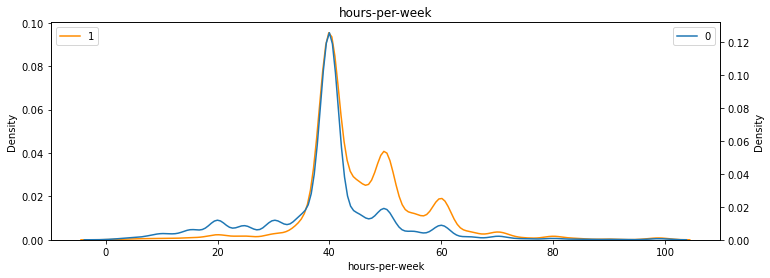

Feature name: hours-per-week
Descriptive information:
         count       mean        std  min   25%   50%   75%   max
label                                                            
0      22654.0  39.348592  11.950774  1.0  38.0  40.0  40.0  99.0
1       7508.0  45.706580  10.736987  1.0  40.0  40.0  50.0  99.0


In [17]:
kdeplot_attributes = ['age', 'workclass', 'education-num', 'marital-status',
            'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week'] 
kdeplot_is_categorical = [False, True, False, True, True, True, True, False, False, False]

for i in range(len(kdeplot_attributes)):
    attr, is_cate = kdeplot_attributes[i], kdeplot_is_categorical[i]
    display_kdeplot(data, attr, 'label', is_cate)

- **Remarks:**
    - a) 'age' is one important attribute, which corresponds to our intuition. 
        - for very young people (highly likely to be students), they are more likely to have no incomes, which belongs to '0' class
        - for people whose age between 30 and 50, they achieve their stable bisuness, which means they are more likely to belong to '1' class
    - b) In 'workcalss' attribute, there are 2 attributes which will be beneficial to our prediction:
        - 'Federal-gov' and 'Self-emp-inc'
        - These 2 workclass belong to the 'high-incomes' workclass
    - c) 'education-num' is the attribute that very close to our intuition.
        - the fact is that, for people who are well-educated, i.e., 'education-num' > 15, they are more likely to do jobs like research topics. This means, **they may not have so many incomes**.
        - for people who receive not so many education, i.e., 'education-num' < 10, their job may not pay them a lot!
        - for the rest of people, they are more likely to earn over $50K
    - d) From 'marital-status' and 'relationship', people with family tend to earn more!
        - **it seems like this is one important feature**
    - e) It seems like 'race' is not an important feature
        - we can dive into more details about this through **boxplot**
    - f) From 'sex', it is the fact that, male earn more than female
        - we can check more details through **boxplot**
    - g) Among 'capital-gain' and 'capital-loss', it seems that there exists many outliers
        - **it seems that these 2 attributes are too noisy**
        - more details should be developed through **boxplot**
    - h) In 'hours-per-week', it tells us people work for more hours will not earn more, which is somehow contradicted to our intuition!

- 2. use **'boxplot'** to achieve more details about 'capital-gain' and 'capital-loss' attributes
    - since **these 2 attributes contain many outliers**, it is unclear to use kdeplot to do visualization

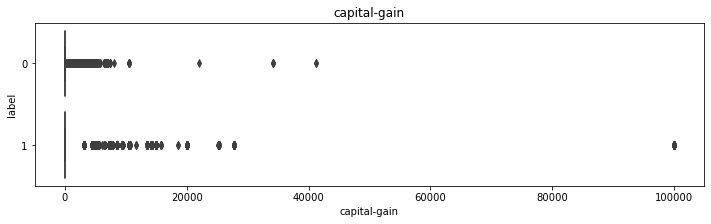

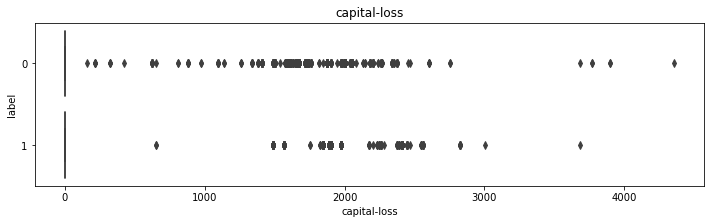

In [18]:
boxplot_attributes = ['capital-gain', 'capital-loss']

for i in range(len(boxplot_attributes)):
    attr = boxplot_attributes[i]
    plt.figure(figsize = (12, 3))
    sns.boxplot(x=attr, y='label', data = data, orient = 'h')
    plt.title(attr)
    plt.show()

- it can be observed that, in 'capital-gain', there exists extreme outliers which are close to '100,000'!
    - we should kick out those outliers

In [19]:
data[data['capital-gain'] >= 90000]['capital-gain']

1246     99999.0
1368     99999.0
1482     99999.0
1528     99999.0
1616     99999.0
          ...   
31111    99999.0
31828    99999.0
31972    99999.0
32238    99999.0
32518    99999.0
Name: capital-gain, Length: 148, dtype: float64

In [20]:
data = data[data['capital-gain'] <= 90000]
data.shape

(30014, 14)

- boxplot again

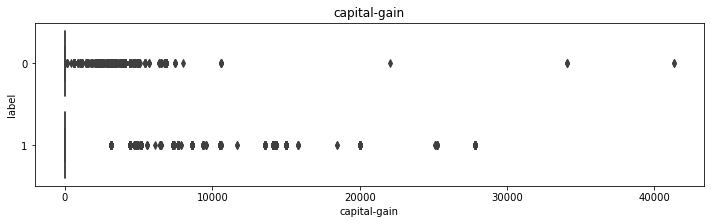

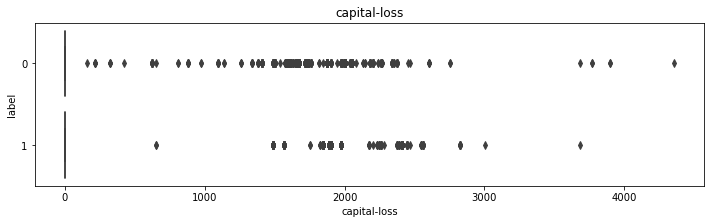

In [21]:
boxplot_attributes = ['capital-gain', 'capital-loss']

for i in range(len(boxplot_attributes)):
    attr = boxplot_attributes[i]
    plt.figure(figsize = (12, 3))
    sns.boxplot(x=attr, y='label', data = data, orient = 'h')
    plt.title(attr)
    plt.show()

- **Remarks**:
    - Except for some outliers (especially in 0-class), 1-class will have higher attribute values **in the average sense**;
    - However, **most of these 2 attributes have 0 value**;
    - Here comes the **most important observation**:
        - although after kicking out outliers, you can still see that, these 2 attributes have very **large scale** relatively
        - this will make those ML model which **trained with GD converge extremely slow!!!**
            - the reason comes from the ill-conditioning of loss function landscape
        - **the solution is, we should do normalization (at least for these 2 attributes) in data pre-processing step**
- This is the **end of EDA part**. We now have a more precise understanding of the whole dataset, including some interesting observation as we mentioned before. Moreover, at this time step, we **have done part of the data cleaning jobs*. That is, we have **kicked out**:
    - 1. all null values;
    - 2. part of outliers;
- The only things we need to do in the data pre-processing step is:
    - 1. one-hot encoding for categorical data;
    - 2. training-testing dataset split;
    - 3. do **normalization** for each numerical attribute;

# 2. Data Pre-processing

In [22]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0


In [23]:
data.shape

(30014, 14)

## 2.1 One-hot encoding

In [24]:
# multi-class
multi_nominal_cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
# bi-class
doub_nominal_cat = ['sex']
# numerical
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# target
target = 'label'

In [25]:
# multi-class
data_impute = pd.get_dummies(data[multi_nominal_cat])

# numerical
data_impute[numerical] = data[numerical].astype(float)

# bi-class
data_impute['sex_male'] = data['sex'].apply(lambda x: 1 if x == ' Male' else 0)

# target
data_impute[target] = data[target]

In [26]:
data_impute

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,...,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,education-num,capital-gain,capital-loss,hours-per-week,sex_male,label
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,39.0,13.0,2174.0,0.0,40.0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,50.0,13.0,0.0,0.0,13.0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,38.0,9.0,0.0,0.0,40.0,1,0
3,0,0,1,0,0,0,0,0,1,0,...,1,0,0,53.0,7.0,0.0,0.0,40.0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,28.0,13.0,0.0,0.0,40.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,1,0,0,0,0,0,0,0,...,1,0,0,27.0,12.0,0.0,0.0,38.0,0,0
32557,0,0,1,0,0,0,0,0,0,0,...,1,0,0,40.0,9.0,0.0,0.0,40.0,1,1
32558,0,0,1,0,0,0,0,0,0,0,...,1,0,0,58.0,9.0,0.0,0.0,40.0,0,0
32559,0,0,1,0,0,0,0,0,0,0,...,1,0,0,22.0,9.0,0.0,0.0,20.0,1,0


- reset index

In [27]:
data_impute.reset_index(drop = True, inplace = True)
data_impute

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,...,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,education-num,capital-gain,capital-loss,hours-per-week,sex_male,label
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,39.0,13.0,2174.0,0.0,40.0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,50.0,13.0,0.0,0.0,13.0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,38.0,9.0,0.0,0.0,40.0,1,0
3,0,0,1,0,0,0,0,0,1,0,...,1,0,0,53.0,7.0,0.0,0.0,40.0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,28.0,13.0,0.0,0.0,40.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30009,0,0,1,0,0,0,0,0,0,0,...,1,0,0,27.0,12.0,0.0,0.0,38.0,0,0
30010,0,0,1,0,0,0,0,0,0,0,...,1,0,0,40.0,9.0,0.0,0.0,40.0,1,1
30011,0,0,1,0,0,0,0,0,0,0,...,1,0,0,58.0,9.0,0.0,0.0,40.0,0,0
30012,0,0,1,0,0,0,0,0,0,0,...,1,0,0,22.0,9.0,0.0,0.0,20.0,1,0


In [28]:
data_impute.shape

(30014, 103)

- **Remarks**:
    - After one-hot encoding, the attributes number comes to 103 from 14 (including the label)
    - We **use this imputed data** to generate the training set and testing set, which will be applied in model training and evaluation process

## 2.2 Training-testing sets generation

In [29]:
features_to_use = list(data_impute.columns[:-1])
target = [data_impute.columns[-1]]
test_size = 0.1
random_state = 519

X_train, y_train, X_test, y_test, df_test = train_test_generation(data_impute, features_to_use, target, test_size, random_state)

Label distribution:
label
0.0      20421
1.0       6591
dtype: int64 (training)
Label distribution:
label
0.0      2233
1.0       769
dtype: int64 (testing)


In [30]:
X_train.shape, y_train.shape

((27012, 102), (27012, 1))

In [31]:
X_test.shape, y_test.shape

((3002, 102), (3002, 1))

In [32]:
# contains the label
df_test.shape

(3002, 103)

In [33]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

## 2.3 Normalization (based on training data)

In [34]:
# use training sample to calculate the mean and variance
scaler = preprocessing.StandardScaler().fit(X_train)

In [35]:
# apply to the whole dataset
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

In [36]:
# to DataFrame
X_train_standard = pd.DataFrame(X_train_standard, columns = X_train.columns)
X_test_standard = pd.DataFrame(X_test_standard, columns = X_test.columns)

In [37]:
X_train_standard.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,education-num,capital-gain,capital-loss,hours-per-week,sex_male
0,-0.179921,-0.270837,0.593027,-0.191131,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,-0.712403,-0.432218,-0.235148,-0.21905,0.764105,0.693602
1,-0.179921,3.692251,-1.686263,-0.191131,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,0.352686,1.141454,-0.235148,-0.21905,-0.073374,0.693602
2,-0.179921,-0.270837,-1.686263,-0.191131,3.361629,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,0.200531,-0.038800,0.955505,-0.21905,-0.073374,0.693602
3,-0.179921,-0.270837,-1.686263,5.232012,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,2.939332,-0.038800,-0.235148,-0.21905,-0.073374,0.693602
4,-0.179921,-0.270837,0.593027,-0.191131,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,0.352686,-0.432218,-0.235148,-0.21905,0.345365,-1.441749


In [38]:
X_test_standard.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,education-num,capital-gain,capital-loss,hours-per-week,sex_male
0,-0.179921,-0.270837,0.593027,-0.191131,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,-0.027703,-0.432218,-0.235148,-0.21905,-0.073374,0.693602
1,-0.179921,-0.270837,-1.686263,5.232012,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,-0.788481,-0.432218,-0.235148,-0.21905,2.020323,0.693602
2,-0.179921,-0.270837,-1.686263,5.232012,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,0.733075,1.928290,-0.235148,-0.21905,1.601583,0.693602
3,-0.179921,-0.270837,0.593027,-0.191131,-0.297475,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,0.428764,1.141454,-0.235148,-0.21905,-0.073374,0.693602
4,-0.179921,-0.270837,-1.686263,-0.191131,3.361629,-0.213159,-0.021943,-0.168063,-0.190088,-0.113073,...,-0.023572,0.310841,-0.045985,-0.023572,-1.168870,-0.432218,-0.235148,-0.21905,-0.073374,0.693602


# 3. Model Training and Evaluation (Supervised Learning)

## 3.1 DT (baseline)

In [39]:
clf_DT = DecisionTreeClassifier(criterion = 'gini', max_depth = 3)
clf_DT.fit(X_train_standard, y_train)

DecisionTreeClassifier(max_depth=3)

### visualize the result of DT

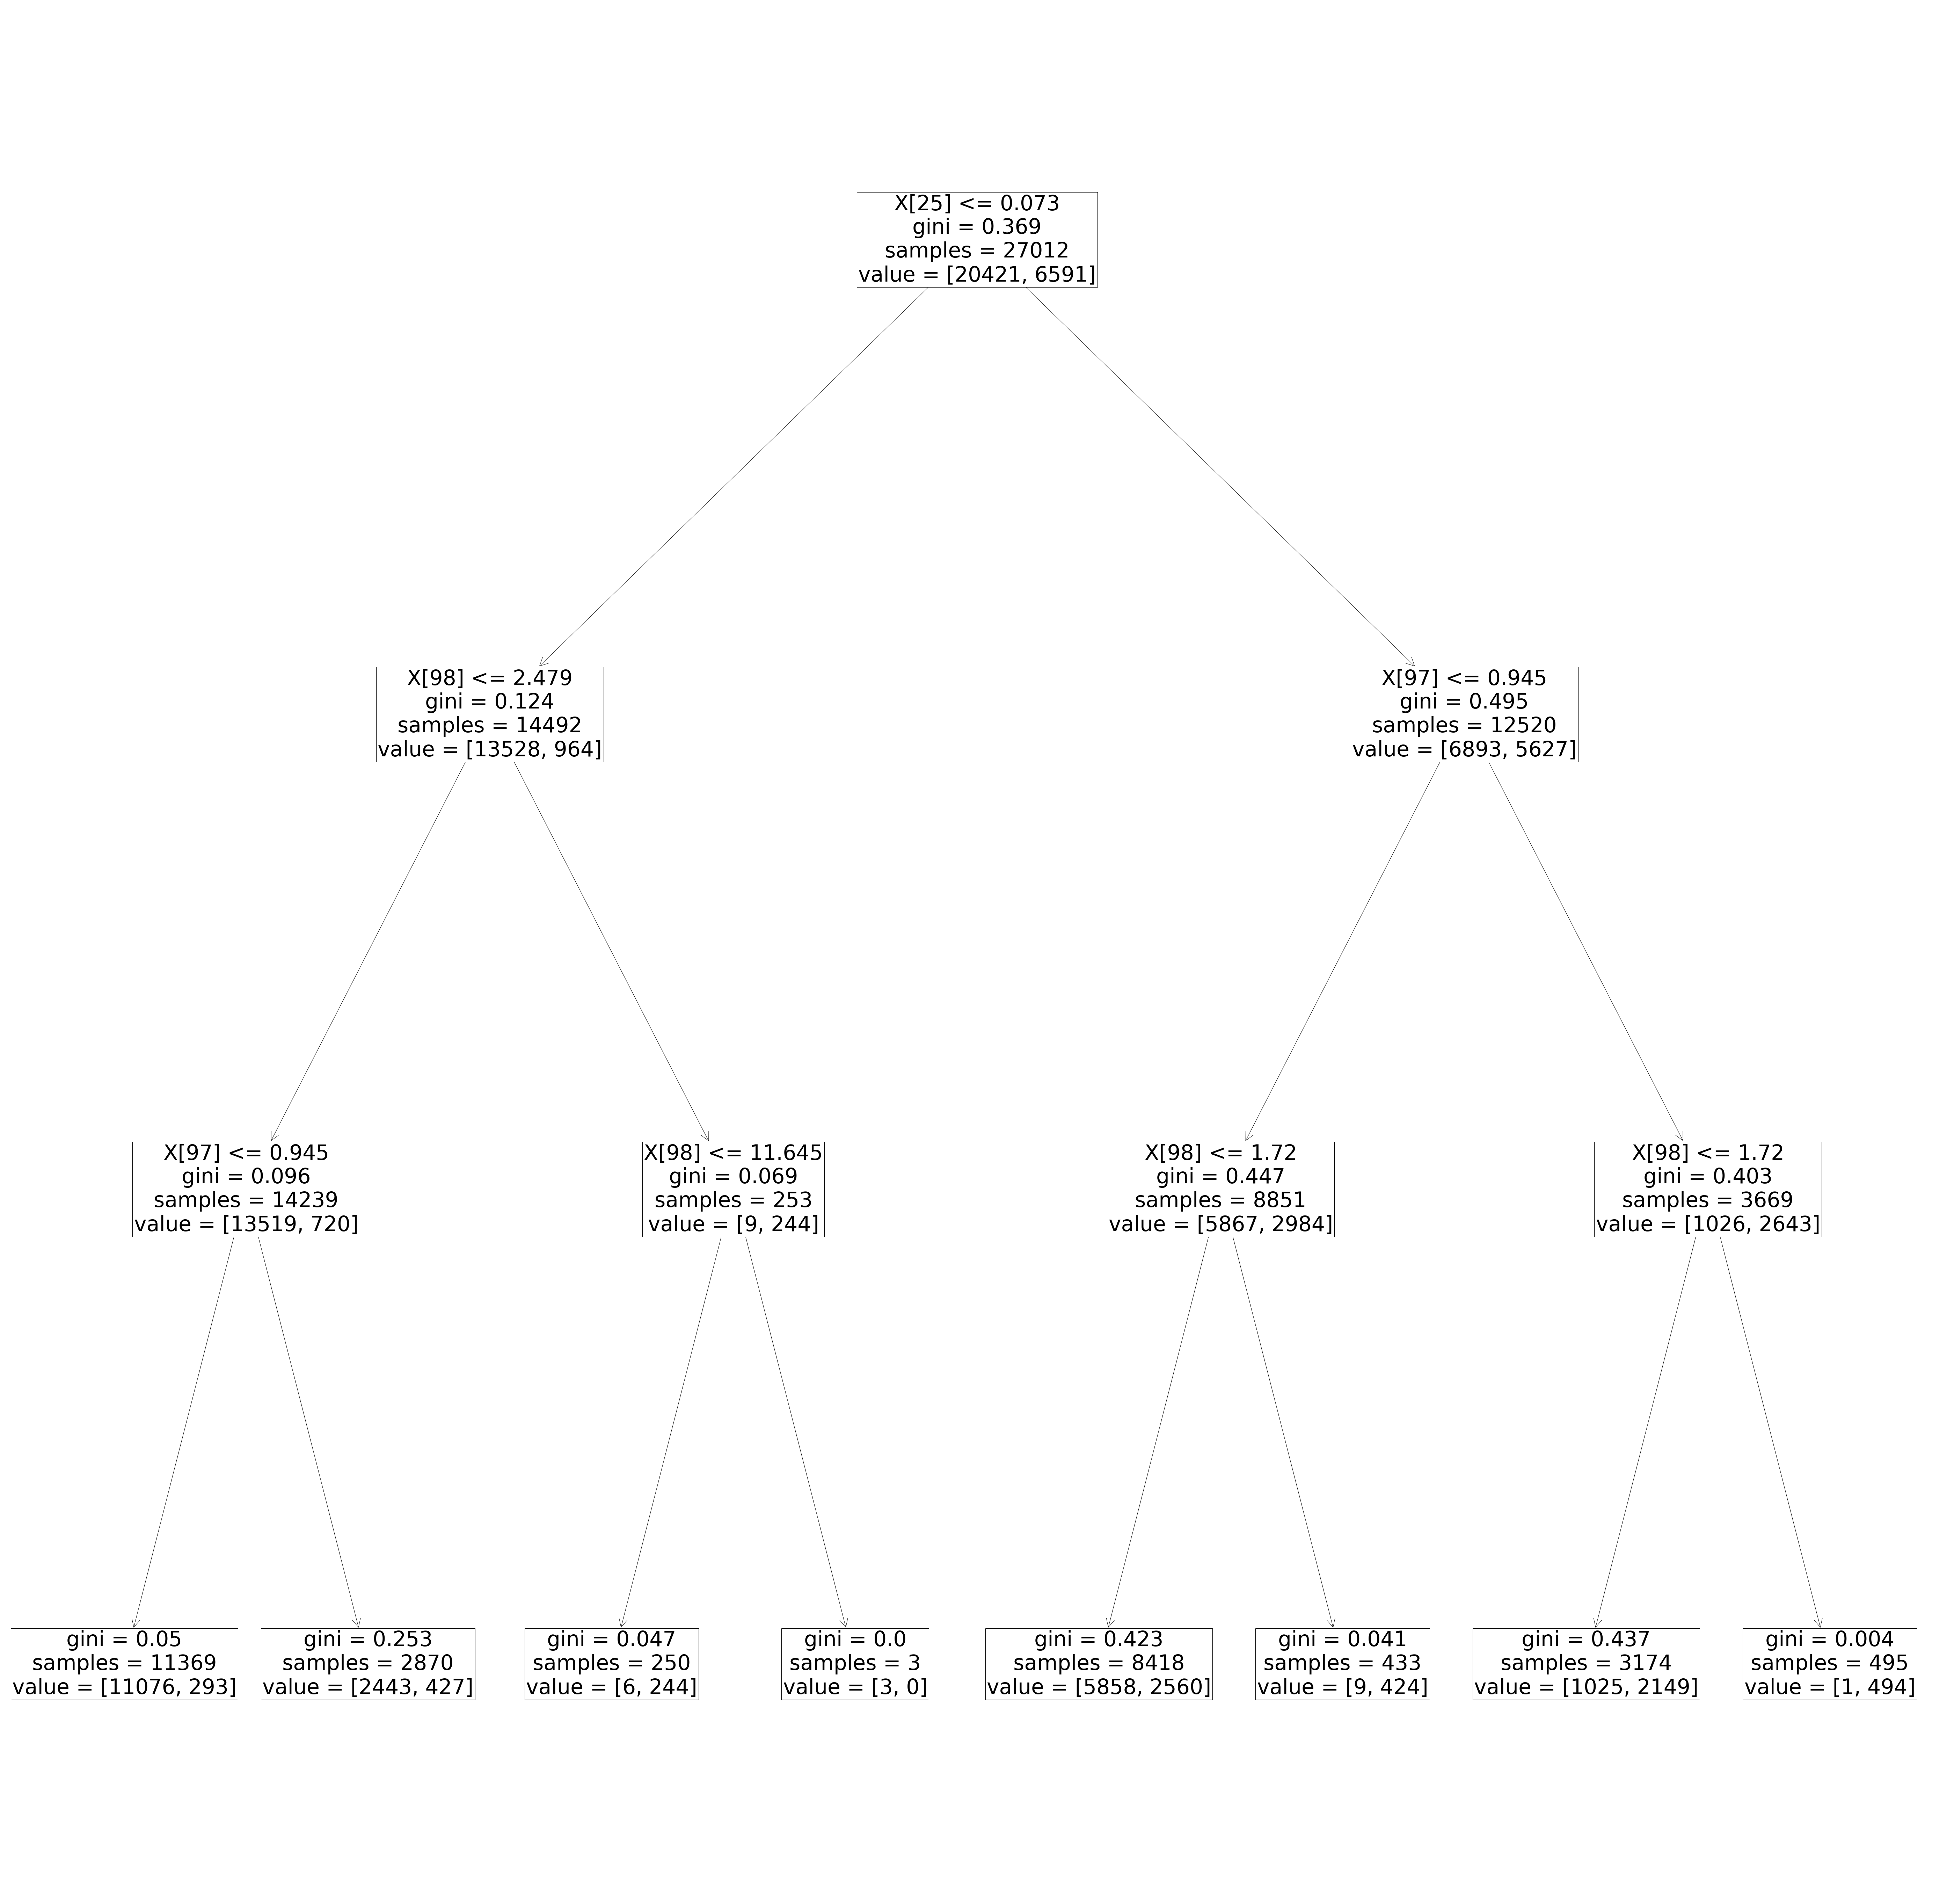

In [40]:
fig, ax = plt.subplots(figsize=(100, 100))
tree.plot_tree(clf_DT, fontsize=60)
plt.show()

In [41]:
X_train.columns[25]

'marital-status_ Married-civ-spouse'

- from the visualization result, it seems the "most important feature" is 'marital-status' since we firstly split the node w.r.t it
    - this **corresponds to our EDA result** (if one has family, then he is more likely to earn more than $50K)

### Evaluation the performance of DT Baseline

In [42]:
test_pred_DT = clf_DT.predict(X_test_standard)
display_model_metrics(y_test, test_pred_DT)

     F1 score: 0.6048
     AUC: 0.7227105883668369
     Accuracy: 0.8354430379746836
     Precision: 0.7858627858627859
     Recall: 0.49154746423927176
	Confusion matrix：
 [[2130  103]
 [ 391  378]]


### Conclusion:
- this is only a toy example, which gives us a naive prediction (baseline) of this problem;
- in this toy example, we can see the procedure of making decision for each testing sample (tree diagram).
    - therefore, we can gain some insights of a relatively good decision-making process
        - the 25-th feature seems very important, which is 'marital-status_ Married-civ-spouse'
        - this **corresponds to our observation** in EDA part
- it should be mentioned that, here, we do not apply CV to select optimal hyper-parameters here, the main reasons are:
    - 1. **for the convenience of visualization**, we fix 'depth' with a small number;
    - 2. this is only a baseline, which aims to **give us some insights about how the prediction task works**!
- in the following discussion, we will try more complicated models, including Logistics Regression, Kernel SVM, Random Forest and XGBoost

## 3.2 Logistic Regression

### a) pre-defined variables

In [43]:
lr_param_grid = {
            'C': [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.5],
            'random_state': [519],
            'class_weight': [{0: 0.3, 1: 0.7}],
            'solver': ['liblinear']
            } 

cv = 5
is_feature_importance, is_shap, is_plot_pr = False, False, True

### b) find optimal hyper-parameters via 5-folds CV!

In [44]:
clf_lr = LogisticRegression()

best_param_lr = model_grid_search(clf_lr, lr_param_grid, cv, X_train_standard, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
====> grid search parameters: 
{
C : [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.5]
random_state : [519]
class_weight : [{0: 0.3, 1: 0.7}]
solver : ['liblinear']
}

====> best estimator: 
{
C : 0.02
class_weight : {0: 0.3, 1: 0.7}
random_state : 519
solver : liblinear
}



### c) construct classifier through optimal hyper-parameters

In [45]:
best_param_lr_save = { 
            'C': 0.02,
            'random_state': 519,
            'class_weight': {0: 0.3, 1: 0.7},
            'solver': 'liblinear'}

clf_lr_opt = LogisticRegression(**best_param_lr_save)

### d) model training and model evaluation
- we **define model training and model evaluation pipeline function** for **probabilistic** model
    - including LR, RF and XGBoost
- for **non-probabilistic model**, we will write codes directly
    - including SVM

Candidate threshold: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
F1-score records: [0.54617193 0.60758644 0.64775314 0.67481005 0.68719696 0.68764277
 0.65890183 0.58359133 0.40772382]
Optimal threshold (Roughly): 0.6

Train:
Label distribution:
label
0.0      20421
1.0       6591
dtype: int64

     F1 score: 0.6876427676663475
     AUC: 0.7973101689633488
     Accuracy: 0.8430697467792092
     Precision: 0.6684813753581662
     Recall: 0.7079350629646488
	Confusion matrix：
 [[18107  2314]
 [ 1925  4666]]

Testing:
Label distribution:
label
0.0      2233
1.0       769
dtype: int64

     F1 score: 0.6894803548795945
     AUC: 0.7943688973239218
     Accuracy: 0.8367754830113258
     Precision: 0.6724351050679852
     Recall: 0.7074122236671001
	Confusion matrix：
 [[1968  265]
 [ 225  544]]
testing:


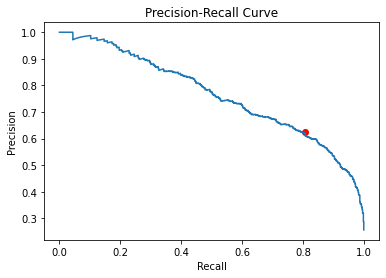

In [46]:
output_lr, pred_prob_lr, opt_threshold_pred_lr = model_train_evaluation_prob_mod(clf_lr_opt, 
                                X_train_standard, y_train, X_test_standard, y_test, is_feature_importance, is_shap, is_plot_pr)

### e) Conclusion
- Compare with our baseline, Logistic Regression Model do much better, in the sense of F1-score measure (**combining precision rate and recall rate**). Reasons can be:
    - within LR model, we tune the hyper-parameters
    - our dataset is label-imbalanced
        - we apply class weight to handle this issue
- This model is also relatively naive. Afterwards, we will try **more complicated models** to see their performance (**Kernel SVM, RF, XGBoost**)

## 3.3 Kernel SVM (not a probabilistic model)

### a) pre-defined variables

In [47]:
svm_param_grid = {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5, 1 ,2],
            'C': [0, 0.2, 0.5, 1, 3],
            'class_weight': [{0: 0.3, 1: 0.7}],
            'random_state': [519]
            } 

cv = 5
is_feature_importance, is_shap, is_plot_pr = False, False, True

### b) find optimal hyper-parameters via 5-folds CV!

In [48]:
clf_svm = svm.SVC()

best_param_svm = model_grid_search(clf_svm, svm_param_grid, cv, X_train_standard, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
====> grid search parameters: 
{
kernel : ['rbf']
gamma : [0.1, 0.5, 1, 2]
C : [0, 0.2, 0.5, 1, 3]
class_weight : [{0: 0.3, 1: 0.7}]
random_state : [519]
}

====> best estimator: 
{
C : 1
class_weight : {0: 0.3, 1: 0.7}
gamma : 0.1
kernel : rbf
random_state : 519
}



### [Extra Part] Comparison between "with normalization" and "with normalization"
- Here, we can use SVM model as a toy example to illustrate the power of normalization!

In [49]:
clf_svm_withnorm = svm.SVC(max_iter = 1000)
clf_svm_withoutnorm = svm.SVC(max_iter = 1000)

In [50]:
clf_svm_withnorm.fit(X_train_standard, y_train)
clf_svm_withoutnorm.fit(X_train, y_train)

SVC(max_iter=1000)

In [51]:
print("=============================================================================================")
print("with normalization")
display_model_metrics(y_test, clf_svm_withnorm.predict(X_test_standard))
print("=============================================================================================")
print("without normalization")
display_model_metrics(y_test, clf_svm_withoutnorm.predict(X_test))

with normalization
     F1 score: 0.5111821086261981
     AUC: 0.6710953501007759
     Accuracy: 0.6432378414390406
     Precision: 0.39381153305203936
     Recall: 0.7282184655396619
	Confusion matrix：
 [[1371  862]
 [ 209  560]]
without normalization
     F1 score: 0.3570424515040765
     AUC: 0.4307869835200448
     Accuracy: 0.23817455029980014
     Precision: 0.22776183644189382
     Recall: 0.8257477243172952
	Confusion matrix：
 [[  80 2153]
 [ 134  635]]


- **illustration**:
    - it can be observed that, for both 1000 iteration, the model without normalization almost learn nothing, while the model with normalization has learnt a lot (but still can keep improving)
    - this is the power of normalization. That is, it can 'normalize' the landscape of loss function, which will **extremely fasten the convergence!!**

### c) construct classifier through optimal hyper-parameters

In [52]:
best_param_svm_save = {
                    'C': 1,
                    'class_weight': {0: 0.3, 1: 0.7},
                    'gamma': 0.1,
                    'kernel': 'rbf',
                    'random_state': 519
                    }

clf_svm_opt = svm.SVC(**best_param_svm_save)

### d) model training and evaluation **[it requires around 5 minutes to train this model]**
- since it is not a probabilistic model, we write the codes for model training and evaluation
- **it will take about 5 minutes!**

In [53]:
clf_svm_opt.fit(X_train_standard, y_train)
y_test_svm, y_train_svm = clf_svm_opt.predict(X_test_standard), clf_svm_opt.predict(X_train_standard)


print("\n=============================================================================================")
print(f'Train:')
print('Label distribution:\n{}\n'.format(y_train.value_counts()))
display_model_metrics(y_train, y_train_svm)
        
print("\n=============================================================================================")
print('Testing:')
print('Label distribution:\n{}\n'.format(y_test.value_counts()))
display_model_metrics(y_test, y_test_svm)


Train:
Label distribution:
label
0.0      20421
1.0       6591
dtype: int64

     F1 score: 0.7303191857647303
     AUC: 0.836969736522755
     Accuracy: 0.8558048274840812
     Precision: 0.6716760061130922
     Recall: 0.8001820664542558
	Confusion matrix：
 [[17843  2578]
 [ 1317  5274]]

Testing:
Label distribution:
label
0.0      2233
1.0       769
dtype: int64

     F1 score: 0.6377551020408163
     AUC: 0.7581472381705554
     Accuracy: 0.8107928047968022
     Precision: 0.6257822277847309
     Recall: 0.6501950585175552
	Confusion matrix：
 [[1934  299]
 [ 269  500]]


## 3.4 Random Forest

### a) pre-defined variables

In [54]:
rf_param_grid = {
            'max_depth': [8, 16, 32],
            'n_estimators': [256],
            'min_samples_leaf' : [5, 20, 30],
            'bootstrap': [True],  
            'criterion':['gini'],
            'random_state': [519], 
            'class_weight': [{0: 0.3, 1: 0.7}]
            }  

cv = 5
is_feature_importance, is_shap, is_plot_pr = False, False, True

### b) find optimal hyper-parameters via 5-folds CV!

In [55]:
clf_rf = RandomForestClassifier()

best_param_rf = model_grid_search(clf_rf, rf_param_grid, cv, X_train_standard, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
====> grid search parameters: 
{
max_depth : [8, 16, 32]
n_estimators : [256]
min_samples_leaf : [5, 20, 30]
bootstrap : [True]
criterion : ['gini']
random_state : [519]
class_weight : [{0: 0.3, 1: 0.7}]
}

====> best estimator: 
{
bootstrap : True
class_weight : {0: 0.3, 1: 0.7}
criterion : gini
max_depth : 32
min_samples_leaf : 5
n_estimators : 256
random_state : 519
}



### c) construct classifier through optimal hyper-parameters

In [56]:
best_param_rf_save = {
                        'bootstrap' : True,
                        'class_weight' : {0: 0.3, 1: 0.7},
                        'criterion' : 'gini',
                        'max_depth' : 32,
                        'min_samples_leaf' : 5,
                        'n_estimators' : 256,
                        'random_state' : 519
                    }

clf_rf_opt = RandomForestClassifier(**best_param_rf_save)

### d) model training and model evaluation

Candidate threshold: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
F1-score records: [0.55381119 0.62210109 0.66948973 0.70579923 0.73078693 0.73156161
 0.68465608 0.57234064 0.30340398]
Optimal threshold (Roughly): 0.6

Train:
Label distribution:
label
0.0      20421
1.0       6591
dtype: int64

     F1 score: 0.7315616144596768
     AUC: 0.8209332713428307
     Accuracy: 0.8702428550273952
     Precision: 0.7386328487472935
     Recall: 0.7246244879380974
	Confusion matrix：
 [[18731  1690]
 [ 1815  4776]]

Testing:
Label distribution:
label
0.0      2233
1.0       769
dtype: int64

     F1 score: 0.7064343163538874
     AUC: 0.7987656485033284
     Accuracy: 0.8540972684876749
     Precision: 0.7289073305670816
     Recall: 0.6853055916775033
	Confusion matrix：
 [[2037  196]
 [ 242  527]]
testing:


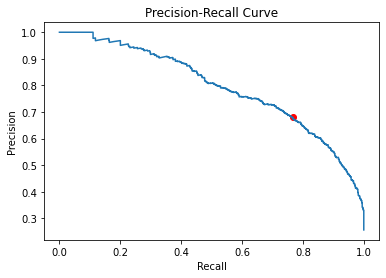

In [57]:
output_rf, pred_prob_rf, opt_threshold_pred_rf = model_train_evaluation_prob_mod(clf_rf_opt, 
                                X_train_standard, y_train, X_test_standard, y_test, is_feature_importance, is_shap, is_plot_pr)

## 3.5 Xgboost

### a) pre-defined variables

In [58]:
xgb_param_grid = {
            'gamma': [0.5, 1, 2],
            'colsample_bytree': [0.8],
            'max_depth': [5, 10, 15],
            'random_state': [519],
            'n_estimators': [256],
            'learning_rate': [0.2]
            }              

cv = 5
is_feature_importance, is_shap, is_plot_pr = False, False, True

### b) find optimal hyper-parameters via 5-folds CV!

In [59]:
clf_xgb = xgb.XGBClassifier() 

best_param_xgb = model_grid_search(clf_xgb, xgb_param_grid, cv, X_train_standard, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
====> grid search parameters: 
{
gamma : [0.5, 1, 2]
colsample_bytree : [0.8]
max_depth : [5, 10, 15]
random_state : [519]
n_estimators : [256]
learning_rate : [0.2]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 1
learning_rate : 0.2
max_depth : 5
n_estimators : 256
random_state : 519
}



### c) construct classifier through optimal hyper-parameters

In [60]:
best_param_xgb_save = {
                        'colsample_bytree' : 0.8,
                        'gamma' : 1,
                        'learning_rate' : 0.2,
                        'max_depth' : 5,
                        'n_estimators' : 256,
                        'random_state' : 519
                    }

clf_xgb_opt = xgb.XGBClassifier(**best_param_xgb_save)

### d) model training and model evaluation

Candidate threshold: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
F1-score records: [0.6701117  0.72983294 0.75783438 0.76692514 0.74874661 0.70915619
 0.64531389 0.54074155 0.44447064]
Optimal threshold (Roughly): 0.4

Train:
Label distribution:
label
0.0      20421
1.0       6591
dtype: int64

     F1 score: 0.7669251416641814
     AUC: 0.8490680818296925
     Accuracy: 0.8842736561528209
     Precision: 0.7539950153936373
     Recall: 0.7803064785313306
	Confusion matrix：
 [[18743  1678]
 [ 1448  5143]]

Testing:
Label distribution:
label
0.0      2233
1.0       769
dtype: int64

     F1 score: 0.7332053742802304
     AUC: 0.8230767707696992
     Accuracy: 0.8610926049300467
     Precision: 0.7216624685138538
     Recall: 0.7451235370611183
	Confusion matrix：
 [[2012  221]
 [ 196  573]]
testing:


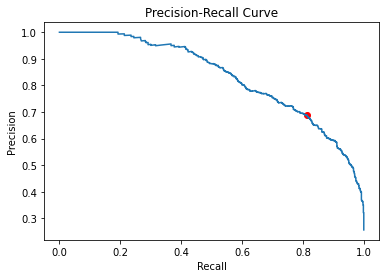

In [61]:
output_xgb, pred_prob_xgb, opt_threshold_pred_xgb = model_train_evaluation_prob_mod(clf_xgb_opt, 
                                X_train_standard, y_train, X_test_standard, y_test, is_feature_importance, is_shap, is_plot_pr)

## 3.6 Conclusion
- our choice of performance metric is f1-score, which can be one measure for both recall and prediction rate
- for our 5 model, the f1-score on testing set can be listed as follows:
    - fix hyper-parameters (Baseline)
        - DT: 0.6 
    - use 5-folds CV to choose hyper-parameters based on training set
        - Logistic Regression: 0.687 
        - Kernel SVM (RBF): 0.637
        - Random Forest: 0.706
        - XGBoost: 0.733
- **Remarks**:
    - 1. for Kernel SVM, it takes quite long time to train model (**longest training time among 5 models**)
        - Reasons might be, it still need to solve a Quadratic Program iteratively, which can be difficult compared with other cases;
    - 2. compared between LR and Kernel SVM, LR is better!
        - Possible reasons can be, 
            - On one hand, LR can capture the non-lieanrity better through sigmoid activation function. 
            - On the other hand, it is difficult for Kernel SVM to solve the Quadratic Program, which means it can not solve the optimization problem well enough.
    - 3. Random Forest performs much better, and XGBoost is the best model among all.
        - also, this 2 models train very fast!

# 4. Unsupervised Learning Task
- apply t-SNE to do visualization (through dimensionality reduction)
- apply PCA to do dimensionality reduction
    - use explained_variance_ratio to determine how many components should be used

## 4.1 t-SNE

### Data Transformation

In [62]:
tsne = TSNE(n_components=2) 
X_train_tsne = tsne.fit_transform(X_train_standard) 

In [63]:
np_train_tsne = np.vstack((X_train_tsne.T, y_train['label'])).T 
df_train_tsne = pd.DataFrame(np_train_tsne, columns=['Dim1', 'Dim2', 'label']) 
df_train_tsne.head()

,Dim1,Dim2,label
0,-26.721462,-47.702477,0.0
1,5.126101,-37.224514,0.0
2,1.881391,-65.090797,1.0
3,32.688038,-5.841592,0.0
4,7.768140,25.749826,0.0


### Visualization

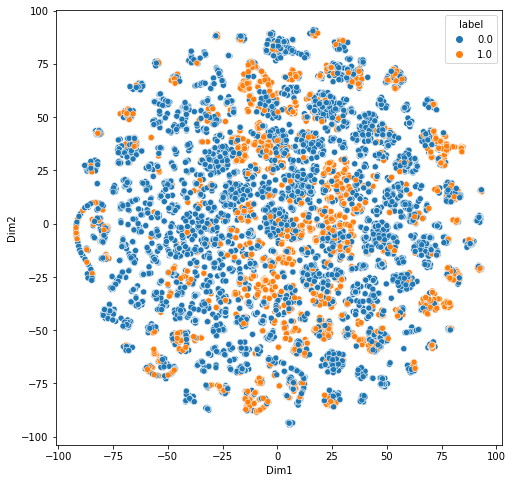

In [64]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=df_train_tsne, hue='label', x = 'Dim1', y = 'Dim2') 
plt.show()

- **Remarks**:
    - t-SNE is an algorithm that aims to preserve more structure information in high-dimensional space compared with tranditional PCA
        - try to deal with crowded issues in visualization through PCA
    - give us more intuition of the spatial distribution of data over the space
    - our aim is to do visualization throught t-SNE unsupervised learning method
        - can tell us how data is distributed (cluster) more clearly

## 4.2 PCA

### Data transformation
- here, we set the threshold of explained_variance_ratio as 0.9 to determine the number of components
- we will **fit the PCA model with training data**, and use this model to transform both training and testing data

In [65]:
pca = PCA(n_components=0.9)
pca.fit(X_train_standard)

PCA(n_components=0.9)

- details about explained_variance_ratio

In [66]:
print(pca.explained_variance_ratio_)
print(pca.n_components_)

[0.04076781 0.02917918 0.02546457 0.02215615 0.01895851 0.01726957
 0.01566772 0.01510614 0.01407573 0.01350065 0.01292787 0.01260854
 0.01234331 0.01213224 0.01188711 0.0117563  0.01155182 0.01141462
 0.01119827 0.01107093 0.01097734 0.01089712 0.01083232 0.01074995
 0.01073606 0.01064774 0.01060511 0.01054598 0.01047763 0.01037971
 0.0103326  0.01030731 0.01027085 0.01024908 0.01018672 0.01011569
 0.01010354 0.01008302 0.01001118 0.00998543 0.0099164  0.00990867
 0.00987741 0.0098487  0.00984093 0.00983435 0.00982352 0.00981581
 0.00981405 0.00981145 0.00980873 0.00980077 0.00979184 0.00977536
 0.00976844 0.00976037 0.00973969 0.0097127  0.00970561 0.00967637
 0.0096692  0.0096436  0.0096403  0.00959003 0.0095408  0.00953117
 0.00946955 0.00941669 0.00935669 0.00932112 0.00929793 0.00923175
 0.00907305 0.00901543 0.00893501 0.00887392 0.00881245 0.00867084]
78


In [67]:
X_train_PCA_np = pca.transform(X_train_standard)
X_test_PCA_np = pca.transform(X_test_standard)

### Comparison between before and after PCA dimensionality reduction

In [68]:
X_train_PCA, X_test_PCA = pd.DataFrame(X_train_PCA_np), pd.DataFrame(X_test_PCA_np)
print('========================================================================')
print('Before Dimensionality Reduction:')
print('Training: {}'.format(X_train_standard.shape))
print('Testing: {}'.format(X_test_standard.shape))
print('========================================================================')
print('After Dimensionality Reduction:')
print('Training: {}'.format(X_train_PCA.shape))
print('Testing: {}'.format(X_test_PCA.shape))

Before Dimensionality Reduction:
Training: (27012, 102)
Testing: (3002, 102)
After Dimensionality Reduction:
Training: (27012, 78)
Testing: (3002, 78)


In [69]:
X_train_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-1.130674,0.554641,-1.411584,0.568652,0.396166,-0.418980,-2.416540,-0.539272,0.958492,0.973291,...,0.120952,-0.126769,0.046225,0.358055,-0.105254,0.077374,0.130384,0.333992,-0.454192,-0.266758
1,2.845914,-0.716265,-0.115453,0.170971,-0.392368,1.344624,0.195578,-0.321686,0.318793,1.213682,...,0.414576,0.438309,-0.232435,0.668108,-0.411262,-0.277365,-0.498166,0.500646,-0.909266,-0.481904
2,2.306202,0.891543,-0.521082,-0.319033,-0.299607,1.252114,-0.133638,1.040406,-0.812655,-0.512871,...,-0.813107,-0.187088,0.364946,0.075945,-1.065144,-0.809936,-0.108767,-0.378989,-0.433315,0.580433
3,3.410071,-0.182630,-0.112759,-0.906691,-0.056772,0.449100,0.121713,1.375606,-3.038808,-1.106173,...,0.227688,-0.765975,-0.560385,0.006872,-0.120956,-0.157163,-0.407453,0.400105,-0.453328,-0.637810
4,-2.588395,0.748609,1.268976,-3.127327,-2.636256,-0.823176,0.148284,-2.514213,0.120398,-0.919708,...,1.272389,0.236979,0.792106,0.664033,-0.537543,0.651034,0.650315,0.222916,0.768657,-0.596063


In [70]:
X_train_PCA_visual = X_train_PCA[[0, 1]]
X_train_PCA_visual.columns = ['Dim1', 'Dim2']
X_train_PCA_visual['label'] = y_train
X_train_PCA_visual.head()

,Dim1,Dim2,label
0,-1.130674,0.554641,0.0
1,2.845914,-0.716265,0.0
2,2.306202,0.891543,1.0
3,3.410071,-0.182630,0.0
4,-2.588395,0.748609,0.0


### Visualization

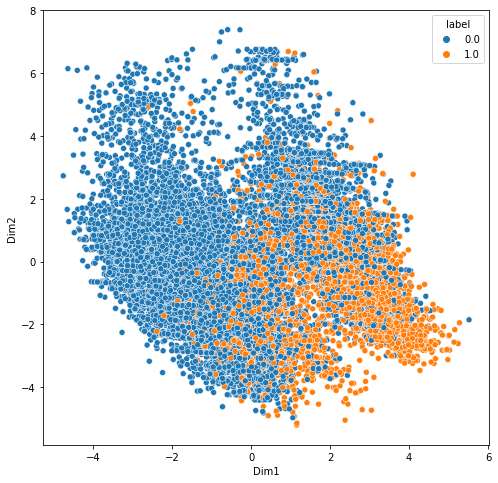

In [71]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=X_train_PCA_visual, hue='label', x = 'Dim1', y = 'Dim2') 
plt.show()

- **Remarks**:
    - t-SNE method:
        - 1. it is a non-linear mapping
            - visualization result is better
        - 2. it has more power to **preserve topological inforamtion** in high-dimensional space
        - 3. it takes more time
    - PCA method:
        - 1. it is a linear mapping
            - **compared with t-SNE, it cannot recap the high-dimensional information well**
        - 2. it is time-efficient
        - 3. it is easier to understand
        - 4. **it can apply to the testing set and combining with model training process**

# 5. Re-trained model through data after dimensionality reduction from PCA
- apply Random Forest and XGBoost to see the performance

## 5.1 PCA + RF

### a) pre-defined variables

In [72]:
rf_param_grid_pca = {
            'max_depth': [8, 16, 32],
            'n_estimators': [256],
            'min_samples_leaf' : [5, 20, 30],
            'bootstrap': [True],  
            'criterion':['gini'],
            'random_state': [519], 
            'class_weight': [{0: 0.3, 1: 0.7}]
            }  

cv = 5
is_feature_importance, is_shap, is_plot_pr = False, False, True

### b) find optimal hyper-parameters via 5-folds CV!

In [73]:
clf_rf_pca = RandomForestClassifier()

best_param_rf_pca = model_grid_search(clf_rf_pca, rf_param_grid_pca, cv, X_train_PCA, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
====> grid search parameters: 
{
max_depth : [8, 16, 32]
n_estimators : [256]
min_samples_leaf : [5, 20, 30]
bootstrap : [True]
criterion : ['gini']
random_state : [519]
class_weight : [{0: 0.3, 1: 0.7}]
}

====> best estimator: 
{
bootstrap : True
class_weight : {0: 0.3, 1: 0.7}
criterion : gini
max_depth : 8
min_samples_leaf : 5
n_estimators : 256
random_state : 519
}



### c) construct classifier through optimal hyper-parameters

In [74]:
best_param_rf_pca_save = {
                        'bootstrap' : True,
                        'class_weight' : {0: 0.3, 1: 0.7},
                        'criterion' : 'gini',
                        'max_depth' : 8,
                        'min_samples_leaf' : 5,
                        'n_estimators' : 256,
                        'random_state' : 519
                        }

clf_rf_pca_opt = RandomForestClassifier(**best_param_rf_pca_save)

### d) model training and model evaluation

Candidate threshold: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
F1-score records: [0.46059673 0.58079187 0.64310703 0.69682576 0.72024361 0.70854152
 0.56687834 0.31340466 0.06004415]
Optimal threshold (Roughly): 0.5

Train:
Label distribution:
label
0.0      20421
1.0       6591
dtype: int64

     F1 score: 0.720243611809877
     AUC: 0.8373938204794537
     Accuracy: 0.8435510143639864
     Precision: 0.6388725778038755
     Recall: 0.8253679259596419
	Confusion matrix：
 [[17346  3075]
 [ 1151  5440]]

Testing:
Label distribution:
label
0.0      2233
1.0       769
dtype: int64

     F1 score: 0.684757505773672
     AUC: 0.802717483404448
     Accuracy: 0.8181212524983345
     Precision: 0.6157840083073728
     Recall: 0.7711313394018205
	Confusion matrix：
 [[1863  370]
 [ 176  593]]
testing:


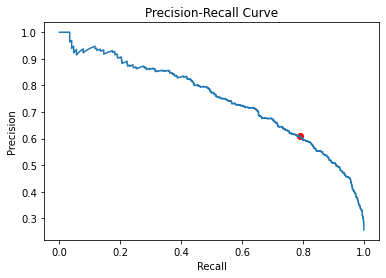

In [75]:
output_rf_pca, pred_prob_rf_pca, opt_threshold_pred_rf_pca = model_train_evaluation_prob_mod(clf_rf_pca_opt, 
                                X_train_PCA, y_train, X_test_PCA, y_test, is_feature_importance, is_shap, is_plot_pr)

## 5.2 PCA + XGBoost

### a) pre-defined variables

In [76]:
xgb_param_grid_pca = {
            'gamma': [0.5, 1, 2],
            'colsample_bytree': [0.8],
            'max_depth': [5, 10, 15],
            'random_state': [519],
            'n_estimators': [256],
            'learning_rate': [0.2]
            }              

cv = 5
is_feature_importance, is_shap, is_plot_pr = False, False, True

### b) find optimal hyper-parameters via 5-folds CV!

In [77]:
clf_xgb_pca = xgb.XGBClassifier() 

best_param_xgb_pca = model_grid_search(clf_xgb_pca, xgb_param_grid_pca, cv, X_train_PCA, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
====> grid search parameters: 
{
gamma : [0.5, 1, 2]
colsample_bytree : [0.8]
max_depth : [5, 10, 15]
random_state : [519]
n_estimators : [256]
learning_rate : [0.2]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 2
learning_rate : 0.2
max_depth : 5
n_estimators : 256
random_state : 519
}



### c) construct classifier through optimal hyper-parameters

In [78]:
best_param_xgb_pca_save = {
                            'colsample_bytree' : 0.8,
                            'gamma' : 2,
                            'learning_rate' : 0.2,
                            'max_depth' : 5,
                            'n_estimators' : 256,
                            'random_state' : 519
                        }


clf_xgb_pca_opt = xgb.XGBClassifier(**best_param_xgb_pca_save)

### d) model training and model evaluation

Candidate threshold: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
F1-score records: [0.69492961 0.78053204 0.82991831 0.85108879 0.84330621 0.80302241
 0.72959667 0.60230274 0.39917446]
Optimal threshold (Roughly): 0.4

Train:
Label distribution:
label
0.0      20421
1.0       6591
dtype: int64

     F1 score: 0.8510887895006966
     AUC: 0.9098385338198515
     Accuracy: 0.9248111950244335
     Precision: 0.8234960272417707
     Recall: 0.8805947504172357
	Confusion matrix：
 [[19177  1244]
 [  787  5804]]

Testing:
Label distribution:
label
0.0      2233
1.0       769
dtype: int64

     F1 score: 0.6817301484828922
     AUC: 0.7868766586088679
     Accuracy: 0.8357761492338441
     Precision: 0.676923076923077
     Recall: 0.6866059817945384
	Confusion matrix：
 [[1981  252]
 [ 241  528]]
testing:


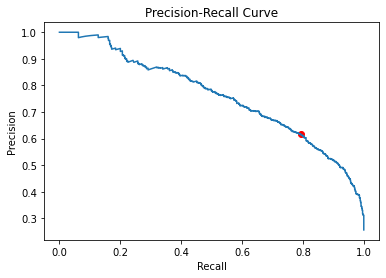

In [79]:
output_xgb_pca, pred_prob_xgb_pca, opt_threshold_pred_xgb_pca = model_train_evaluation_prob_mod(clf_xgb_pca_opt, 
                                X_train_PCA, y_train, X_test_PCA, y_test, is_feature_importance, is_shap, is_plot_pr)

### e) Comparison between Supervised Learning with PCA and without PCA
- After PCA, the number of attributes shrink 30%
- In Random Forest Model
    - before PCA: f1-score = 0.70
    - after PCA: f1-score = 0.68
- In XGBoost
    - before PCA: f1-score = 0.73
    - after PCA: f1-score = 0.68
- Through PCA, we **save 30% space for store the attributes** at the cost of **very small decay w.r.t performance metric**
    - If we are not very sensitive to the performance metric, then use PCA to reduce dimensionality is a good choice;
    - If our first goal is to achieve the best performance and the dataset is not too big, then we should directly use raw data